# ***Parallelization using `SEND API`***

In [129]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

## Define the Report section Structure.

In [130]:
from pydantic import BaseModel, Field
from typing import TypedDict, List, Literal, Annotated

class Section(BaseModel):
    name: Annotated[str, Field(description="This is the name of the section of the report.")]
    description: Annotated[str, Field(description="The brief explanation of the main topics and concept of the section.")]
    
class Sections(BaseModel):
    sections: Annotated[List[Section], Field(description="Sections of the report.")]
    
planner = llm.with_structured_output(Sections)

In [131]:
response = planner.invoke("can you write a details report about the Agentic ai.").model_dump()
response

{'sections': [{'name': 'Introduction',
   'description': 'Agentic AI refers to a type of artificial intelligence that is capable of autonomous decision-making and action. It is designed to mimic human-like intelligence, with the ability to perceive, reason, and act in complex environments.'},
  {'name': 'Key Features',
   'description': 'Agentic AI systems are characterized by their ability to learn from experience, adapt to new situations, and make decisions based on their goals and objectives. They can operate in a variety of domains, including robotics, finance, and healthcare.'},
  {'name': 'Applications',
   'description': "Agentic AI has numerous applications across industries, including autonomous vehicles, personalized medicine, and intelligent virtual assistants. It has the potential to transform businesses and improve people's lives."},
  {'name': 'Benefits',
   'description': 'The benefits of Agentic AI include increased efficiency, improved accuracy, and enhanced decision-m

In [132]:
response['sections'][0]['description']

'Agentic AI refers to a type of artificial intelligence that is capable of autonomous decision-making and action. It is designed to mimic human-like intelligence, with the ability to perceive, reason, and act in complex environments.'

In [133]:
response = planner.invoke("can you write a details report about the Deep Learning.")
response.sections

[Section(name='Introduction', description='Deep learning is a subset of machine learning that involves the use of artificial neural networks to analyze and interpret data.'),
 Section(name='History of Deep Learning', description="The concept of deep learning dates back to the 1940s, but it wasn't until the 2010s that it gained popularity and became a major area of research in the field of artificial intelligence."),
 Section(name='Key Concepts', description='Some key concepts in deep learning include artificial neural networks, deep neural networks, convolutional neural networks, and recurrent neural networks.'),
 Section(name='Applications of Deep Learning', description='Deep learning has a wide range of applications, including image and speech recognition, natural language processing, and autonomous vehicles.'),
 Section(name='Challenges and Limitations', description='Despite its many successes, deep learning also has some challenges and limitations, including the need for large amou

## Graph State

In [134]:
import operator
from langchain_core.messages import HumanMessage , SystemMessage
class State(TypedDict):
    """Description"""
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str
    
    
class WorkerState(TypedDict):
    """description"""
    section: Section
    completed_sections: Annotated[list, operator.add]
    

    

In [135]:

from langgraph.types import Send
#nodes
def orchestrator(state: State):
    """Orchestrator that generate a plan for the report."""
    
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a details plan for the report"),
            HumanMessage(content=(f"hare is the report topics {state['topic']}")),
        ]
    )
    
    print("Report section: ", report_sections.sections)
    
    return {
        "sections": report_sections.sections
    }
    

def llm_call(state: WorkerState):
    print("i'm haere llm call------")
    """Worker writes a section of the report."""
    
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section following the provided name and description. Include no preamble for each section and use markdown format."),
            HumanMessage(content=f"Hare is the section name: {state['section'].name} and description: {state['section'].description}"),
        ]
    )
    
    return {
        "completed_sections": [section.content]
    }
    
def assign_worker(state: State):
    print("----assign worker----")
    """Assign a worker to each section in the plan."""
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


def synthesizer(state: State):
    print("----systhe-----")
    """this function is responsible for merge the all document."""
    completed_sections = state["completed_sections"]
    
    completed_sections_report = "\n\n---\n\n".join(completed_sections)
    # print("Allll contennntntk", completed_sections_report)
    # # from IPython.display import Markdown
    # # Markdown(completed_sections_report)
    return {
        "final_report": completed_sections_report
    }

## workflow

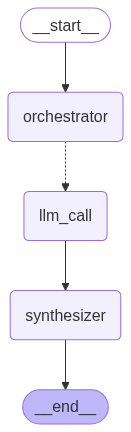

In [136]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
builder = StateGraph(State)

builder.add_node("orchestrator", orchestrator)
builder.add_node("llm_call", llm_call)
builder.add_node("synthesizer", synthesizer)

## add edges
builder.add_edge(START, "orchestrator")
builder.add_conditional_edges(
    "orchestrator",
    assign_worker,
    ["llm_call"]
)
builder.add_edge("llm_call", "synthesizer")
builder.add_edge("synthesizer", END)

graph = builder.compile()
##
display(Image(graph.get_graph().draw_mermaid_png()))

In [137]:
state = graph.invoke(
   {
        "topic": "Create report on Agentic AI"
   }
)

Report section:  [Section(name='Introduction', description='This section will provide an overview of Agentic AI, its definition, and its significance in the current technological landscape.'), Section(name='What is Agentic AI?', description='This section will delve into the specifics of Agentic AI, including its characteristics, capabilities, and applications.'), Section(name='Key Features and Benefits', description='This section will highlight the key features and benefits of Agentic AI, such as its ability to learn, reason, and interact with humans.'), Section(name='Applications and Use Cases', description='This section will explore the various applications and use cases of Agentic AI across industries, including healthcare, finance, and education.'), Section(name='Challenges and Limitations', description='This section will discuss the challenges and limitations of Agentic AI, including issues related to bias, transparency, and accountability.'), Section(name='Future Outlook and Conc

In [138]:
from IPython.display import Markdown
Markdown(state['final_report'])

### Introduction
Agentic AI refers to a type of artificial intelligence that is capable of acting independently, making decisions, and taking actions on its own, often with a high degree of autonomy. This form of AI is designed to simulate human-like intelligence, with the ability to perceive its environment, process information, and execute tasks without explicit programming for every step.

### Description
The significance of Agentic AI in the current technological landscape cannot be overstated. As AI continues to evolve, the development of agentic systems represents a shift towards more sophisticated and human-like intelligence. These systems have the potential to revolutionize various industries, from healthcare and finance to transportation and education, by enabling more efficient, adaptive, and personalized solutions.

### Key Characteristics
- **Autonomy**: The ability to operate and make decisions without human intervention.
- **Adaptability**: The capacity to adjust to new information, environments, or tasks.
- **Goal-Oriented Behavior**: The ability to set objectives and work towards achieving them.

### Significance
The emergence of Agentic AI holds profound implications for society, economy, and technology. It promises to unlock new levels of productivity, innovation, and efficiency. However, it also raises important questions about ethics, safety, and the future of work. As such, understanding Agentic AI is crucial for navigating the opportunities and challenges presented by this rapidly evolving field.

---

### What is Agentic AI?
Agentic AI refers to a type of artificial intelligence that exhibits a high degree of autonomy, agency, and goal-directed behavior. The key characteristics of Agentic AI include:

* **Autonomy**: The ability to operate independently, making decisions and taking actions without human intervention.
* **Self-initiation**: The capacity to initiate actions or tasks on its own, rather than simply responding to external stimuli.
* **Goal-directed behavior**: The ability to set and pursue its own goals, adapting to changing circumstances as needed.

The capabilities of Agentic AI include:

* **Complex problem-solving**: Agentic AI can tackle complex, dynamic problems that require adaptive and creative solutions.
* **Learning and adaptation**: Agentic AI can learn from experience, updating its knowledge and behavior to improve its performance over time.
* **Human-like interaction**: Agentic AI can interact with humans in a more natural, intuitive way, using language, gestures, and other forms of communication.

The applications of Agentic AI are diverse and widespread, including:

* **Virtual assistants**: Agentic AI can power virtual assistants that help users with a range of tasks, from scheduling appointments to making travel arrangements.
* **Smart homes and cities**: Agentic AI can be used to create smart homes and cities that adapt to the needs of their occupants, optimizing energy usage, traffic flow, and public services.
* **Healthcare and medicine**: Agentic AI can help with medical diagnosis, treatment planning, and patient care, improving health outcomes and reducing costs.

---

### Key Features and Benefits

* **Autonomous Learning**: Agentic AI has the ability to learn from various data sources, update its knowledge base, and adapt to new information without requiring manual intervention.
* **Advanced Reasoning**: The AI system can reason and draw inferences from the data it has learned, enabling it to make informed decisions and predictions.
* **Human-AI Interaction**: Agentic AI is designed to interact with humans in a natural and intuitive way, using various interfaces such as text, voice, and visual displays.
* **Contextual Understanding**: The AI system can understand the context of a conversation or situation, enabling it to respond appropriately and provide relevant information.
* **Scalability and Flexibility**: Agentic AI can be applied to various domains and industries, and can be scaled up or down depending on the specific use case.

The benefits of Agentic AI include:

* **Improved Efficiency**: Agentic AI can automate routine and repetitive tasks, freeing up human resources for more strategic and creative work.
* **Enhanced Decision-Making**: The AI system's ability to analyze large amounts of data and make informed decisions can lead to better outcomes and reduced errors.
* **Increased Productivity**: Agentic AI can assist humans in various tasks, such as data analysis, customer service, and content creation, leading to increased productivity and efficiency.
* **Personalized Experiences**: The AI system's ability to understand human preferences and behavior can enable personalized experiences and tailored recommendations.

---

### Applications and Use Cases
Agentic AI has the potential to transform numerous industries and domains, enabling more efficient, effective, and personalized solutions. Some of the key applications and use cases of Agentic AI are highlighted below.

#### Healthcare
* **Personalized Medicine**: Agentic AI can help tailor treatment plans to individual patients based on their unique genetic profiles, medical histories, and lifestyle factors.
* **Clinical Decision Support**: Agentic AI systems can analyze large amounts of medical data to provide healthcare professionals with real-time, evidence-based recommendations for diagnosis, treatment, and patient care.
* **Patient Engagement**: Agentic AI-powered chatbots and virtual assistants can help patients manage chronic conditions, adhere to medication regimens, and stay informed about their health.

#### Finance
* **Risk Management**: Agentic AI can help financial institutions identify and mitigate potential risks, such as credit default, market volatility, and regulatory non-compliance.
* **Portfolio Optimization**: Agentic AI systems can analyze market data and optimize investment portfolios to maximize returns and minimize losses.
* **Customer Service**: Agentic AI-powered chatbots and virtual assistants can provide personalized support to customers, helping them manage accounts, make transactions, and access financial information.

#### Education
* **Personalized Learning**: Agentic AI can help tailor educational content and learning experiences to individual students' needs, abilities, and learning styles.
* **Intelligent Tutoring Systems**: Agentic AI systems can provide one-on-one support to students, offering real-time feedback, guidance, and assessment.
* **Content Creation**: Agentic AI can assist educators in developing high-quality educational content, such as adaptive assessments, interactive simulations, and virtual labs.

#### Other Industries
* **Manufacturing**: Agentic AI can help optimize production processes, predict maintenance needs, and improve product quality.
* **Transportation**: Agentic AI systems can enable more efficient route planning, traffic management, and autonomous vehicle operation.
* **Customer Service**: Agentic AI-powered chatbots and virtual assistants can provide personalized support to customers across various industries, helping them access information, resolve issues, and complete transactions.

---

### Challenges and Limitations

The development and deployment of Agentic AI systems are accompanied by several challenges and limitations that need to be addressed. One of the primary concerns is **bias**. Agentic AI systems can perpetuate and even amplify existing biases present in the data used for their training. These biases can affect decision-making processes, leading to unfair outcomes in critical areas such as hiring, law enforcement, and loan approvals. Ensuring that Agentic AI systems are designed and trained to recognize and mitigate bias is essential.

Another significant challenge is **transparency**. As Agentic AI systems become more autonomous, understanding their decision-making processes becomes increasingly difficult. This lack of transparency can lead to mistrust among users and stakeholders, making it challenging to implement these systems in high-stakes environments. Techniques such as explainable AI (XAI) are being explored to provide insights into the workings of Agentic AI systems, but more research is needed to achieve sufficient transparency.

**Accountability** is also a major concern. With Agentic AI systems operating autonomously, it can be difficult to determine who is responsible when something goes wrong. This issue is particularly problematic in situations where the system's actions result in harm or financial loss. Developing clear guidelines and regulations for accountability in Agentic AI is crucial to ensure that these systems can be used safely and effectively.

Furthermore, **security** poses a significant challenge. Agentic AI systems can be vulnerable to attacks that compromise their integrity and functionality. For instance, adversarial attacks can be used to manipulate the system's decisions or steal sensitive information. Ensuring the security of Agentic AI systems requires the development of robust defense mechanisms and secure-by-design approaches.

Lastly, there are **ethical and societal implications** to consider. The deployment of Agentic AI systems can lead to significant changes in the workforce, potentially displacing jobs and requiring workers to acquire new skills. There are also concerns about the impact of these systems on individual autonomy and freedom. Addressing these challenges requires a multidisciplinary approach that involves not only technologists but also ethicists, policymakers, and social scientists.

---

### Future Outlook and Conclusion

The rapid advancement of Agentic AI is expected to have a profound impact on various aspects of society, transforming the way we live, work, and interact with technology. As Agentic AI continues to evolve, we can anticipate significant improvements in areas such as healthcare, education, and transportation. 

*   **Potential Impact on Society:** Agentic AI has the potential to augment human capabilities, enhancing productivity and efficiency across industries. However, this technological leap also raises concerns about job displacement, data privacy, and the need for robust regulatory frameworks.
*   **Future Applications:** Future applications of Agentic AI may include personalized medicine, autonomous vehicles, and intelligent tutoring systems. These innovations have the potential to revolutionize industries and improve the quality of life for individuals worldwide.
*   **Key Challenges:** Despite the promising prospects, several challenges need to be addressed, including ensuring transparency, accountability, and fairness in Agentic AI decision-making processes.

**Key Takeaways:**

1.  Agentic AI has the potential to drive significant societal and economic change.
2.  Addressing the challenges associated with Agentic AI, such as job displacement and data privacy, is crucial.
3.  Continued research and development are necessary to ensure the safe and responsible deployment of Agentic AI.

In conclusion, Agentic AI represents a transformative technology with far-reaching implications for society. As we move forward, it is essential to prioritize responsible innovation, ensuring that the benefits of Agentic AI are realized while minimizing its risks.